<img src="./images/xarray_aws_zarr.png" />

# Plotting archived HRRR data: 1km reflectivity

## Overview
1. Access archived HRRR data hosted on AWS in Zarr format
2. Visualize one of the variables (1km reflectivity) at an analysis time
3. Use one of **MetPy**'s customized color tables
4. Create and visualize a reflectivity time loop of all forecast hours in an archived HRRR run

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| Zarr, Dask, S3 storage |  2mT notebook| Necessary | |

* **Time to learn**: 30 minutes
***

## Imports

In [1]:
import xarray as xr
import s3fs
import metpy
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import colortables
import pandas as pd

## Access the Zarr-formatted data on AWS</span>

As in the 2m temperature notebook, create objects pointing to the HRRR S3 bucket and object of interest.

<div class="alert alert-info"> <b>Reminder: </b> To interactively browse the contents of this archive, go to the <a href="https://hrrrzarr.s3.amazonaws.com/index.html">HRRR Zarr File browser</a></div>

To access Zarr-formatted data stored in an S3 bucket, we follow a 3-step process:
1. Create URL(s) pointing to the bucket and object(s) that contain the data we want
1. Create *map(s)* to the object(s) with the **s3fs** library's `S3Map` method
1. Pass the *map(s)* to Xarray's `open_dataset` or `open_mfdataset` methods, and specify `zarr` as the format, via the `engine` argument.

Create the URLs

In [2]:
date = '20221014'
hour = '00'
var = 'REFD'
level = '1000m_above_ground'
url1 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var + '/' + level
url2 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var
print(url1)
print(url2)

s3://hrrrzarr/sfc/20221014/20221014_00z_anl.zarr/1000m_above_ground/REFD/1000m_above_ground
s3://hrrrzarr/sfc/20221014/20221014_00z_anl.zarr/1000m_above_ground/REFD


<div class="alert alert-info">
    In this case, <b>hrrrzarr</b> is the S3 <i>bucket</i> name. <b>1000m_above_ground</b> and <b>REFD</b> are both <i>objects</i> within the <b>bucket</b>. The former object has the 1 km reflectivity array, while the latter contains the coordinate arrays of the spatial dimensions of 1 km reflectivity (i.e., x and y).
</div>

Create the S3 maps from the S3 object store.

In [3]:
fs = s3fs.S3FileSystem(anon=True)
file1 = s3fs.S3Map(url1, s3=fs)
file2 = s3fs.S3Map(url2, s3=fs)

Use Xarray's `open_mfdataset` to create a `Dataset` from these two S3 objects.

In [4]:
ds = xr.open_mfdataset([file1,file2], engine='zarr')

Examine the dataset.

In [5]:
ds

<xarray.Dataset>
Dimensions:                  (projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    REFD                     (projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    height                   float64 ...
    pressure                 float64 ...
    time                     datetime64[ns] ...

Remind ourselves of the HRRR's projection info:

### HRRR Grid Navigation: 
     PROJECTION:          LCC                 
     ANGLES:                38.5   -97.5    38.5
     GRID SIZE:             1799    1059
     LL CORNER:            21.1381 -122.7195
     UR CORNER:            47.8422  -60.9168

In [6]:
lon1 = -97.5
lat1 = 38.5
slat = 38.5
projData= ccrs.LambertConformal(central_longitude=lon1,
                             central_latitude=lat1,
                             standard_parallels=[slat,slat],globe=ccrs.Globe(semimajor_axis=6371229,
                                        semiminor_axis=6371229))

<div class="alert alert-warning"><b>Note: </b>
    The HRRR's projection assumes a <i>spherical earth</i>, whose semi-major/minor axes are both equal to 6371.229 km. We therefore need to explicitly define a <code>Globe</code> in Cartopy with these values.
</div>

Examine the dataset's coordinate variables. Each x- and y- value represents distance in meters from the central latitude and longitude.

In [7]:
ds.coords

Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......

Create an object pointing to the dataset's data variable.

In [8]:
scalar = ds.REFD

When we examine the object, we see that it is a special type of `DataArray` ... a *Dask* array.

In [9]:
x = scalar.projection_x_coordinate
y = scalar.projection_y_coordinate

## Visualize 1km Reflectivity at an analysis time

<div class="alert alert-info">
We'll select one of MetPy's color maps, following <a href="https://unidata.github.io/MetPy/latest/examples/formats/GINI_Water_Vapor.html#sphx-glr-examples-formats-gini-water-vapor-py">one of MetPy's gallery examples</a>.
</div>

In [10]:
norm, cmap = colortables.get_with_range('NWSReflectivity', 5,80)

Examine the `cmap` object

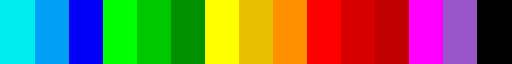

In [11]:
cmap

Set the color map so values under the specified range are shaded in white

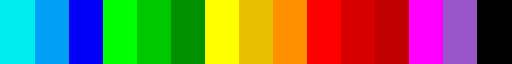

In [12]:
cmap.set_under('w')
cmap

## Plot the map
We'll define the plot extent to nicely encompass the HRRR's spatial domain.

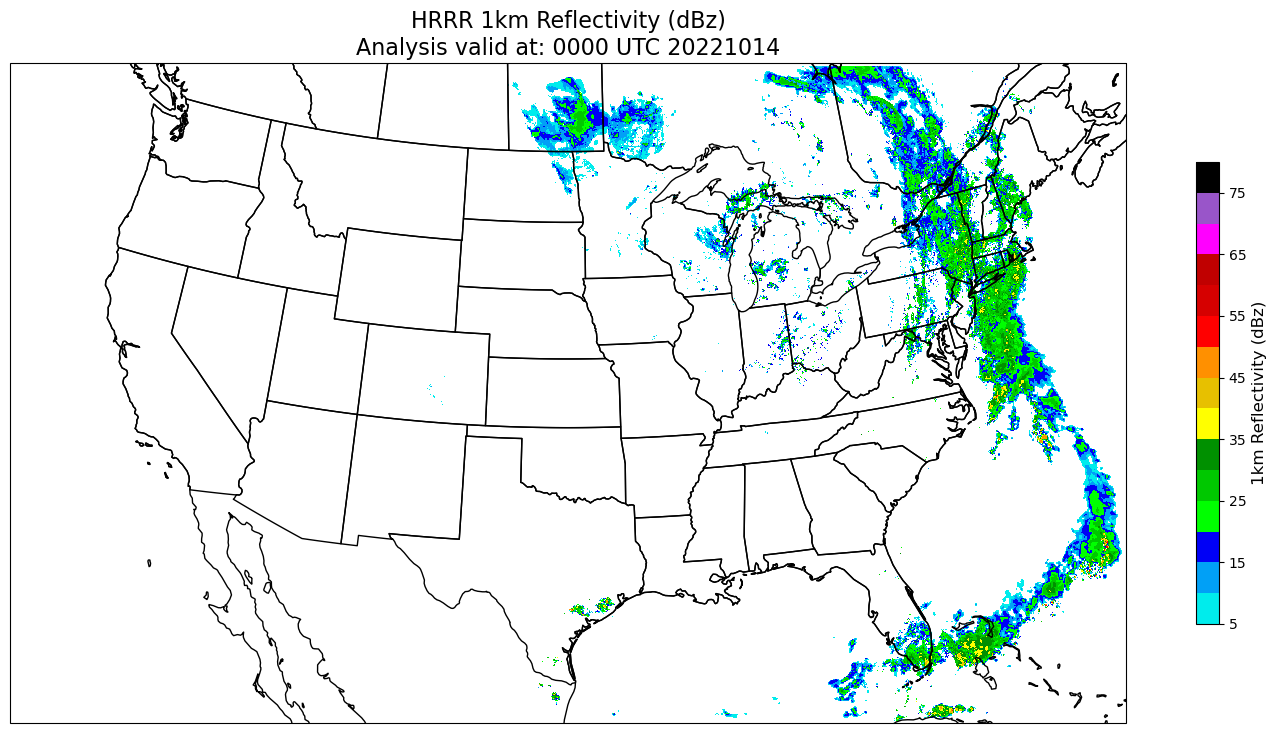

In [13]:
latN = 50.4
latS = 24.25
lonW = -123.8
lonE = -71.2

res = '50m'

fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=projData)
ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))

# Add the title
tl1 = str('HRRR 1km Reflectivity (dBz)')
tl2 = str('Analysis valid at: '+ hour + '00 UTC ' + date  )
plt.title(tl1+'\n'+tl2,fontsize=16)

CM = ax.pcolormesh(x, y, scalar, norm=norm, cmap=cmap)
# Make a colorbar for the color mesh.
cbar = fig.colorbar(CM,shrink=0.5)
cbar.set_label(r'1km Reflectivity (dBz)', size='large')

## Now, create a loop of forecast radar reflectivity for a specific date and time in the archive.

The bucket/object are very similar; it's `fcst` (forecast) instead of `anl` (analysis), though!

In [14]:
date = '20221013'
hour = '18'
var = 'REFD'
level = '1000m_above_ground'
url1 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_fcst.zarr/' + level + '/' + var + '/' + level
url2 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_fcst.zarr/' + level + '/' + var
print(url1)
print(url2)

s3://hrrrzarr/sfc/20221013/20221013_18z_fcst.zarr/1000m_above_ground/REFD/1000m_above_ground
s3://hrrrzarr/sfc/20221013/20221013_18z_fcst.zarr/1000m_above_ground/REFD


In [15]:
fs = s3fs.S3FileSystem(anon=True)
file1 = s3fs.S3Map(url1, s3=fs)
file2 = s3fs.S3Map(url2, s3=fs)

In [16]:
ds = xr.open_mfdataset([file1,file2], engine='zarr')

In [17]:
ds

<xarray.Dataset>
Dimensions:                  (time: 48, projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
  * time                     (time) datetime64[ns] 2022-10-13T19:00:00 ... 20...
Data variables:
    REFD                     (time, projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(48, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...

The `Dataset` is very similar to the analysis; it just has a time dimension too! What times do we have available?

In [18]:
times = ds.time
times

<xarray.DataArray 'time' (time: 48)>
array(['2022-10-13T19:00:00.000000000', '2022-10-13T20:00:00.000000000',
       '2022-10-13T21:00:00.000000000', '2022-10-13T22:00:00.000000000',
       '2022-10-13T23:00:00.000000000', '2022-10-14T00:00:00.000000000',
       '2022-10-14T01:00:00.000000000', '2022-10-14T02:00:00.000000000',
       '2022-10-14T03:00:00.000000000', '2022-10-14T04:00:00.000000000',
       '2022-10-14T05:00:00.000000000', '2022-10-14T06:00:00.000000000',
       '2022-10-14T07:00:00.000000000', '2022-10-14T08:00:00.000000000',
       '2022-10-14T09:00:00.000000000', '2022-10-14T10:00:00.000000000',
       '2022-10-14T11:00:00.000000000', '2022-10-14T12:00:00.000000000',
       '2022-10-14T13:00:00.000000000', '2022-10-14T14:00:00.000000000',
       '2022-10-14T15:00:00.000000000', '2022-10-14T16:00:00.000000000',
       '2022-10-14T17:00:00.000000000', '2022-10-14T18:00:00.000000000',
       '2022-10-14T19:00:00.000000000', '2022-10-14T20:00:00.000000000',
       '2022-10-14T21:00:00.000000000', '2022-10-14T22:00:00.000000000',
       '2022-10-14T23:00:00.000000000', '2022-10-15T00:00:00.000000000',
       '2022-10-15T01:00:00.000000000', '2022-10-15T02:00:00.000000000',
       '2022-10-15T03:00:00.000000000', '2022-10-15T04:00:00.000000000',
       '2022-10-15T05:00:00.000000000', '2022-10-15T06:00:00.000000000',
       '2022-10-15T07:00:00.000000000', '2022-10-15T08:00:00.000000000',
       '2022-10-15T09:00:00.000000000', '2022-10-15T10:00:00.000000000',
       '2022-10-15T11:00:00.000000000', '2022-10-15T12:00:00.000000000',
       '2022-10-15T13:00:00.000000000', '2022-10-15T14:00:00.000000000',
       '2022-10-15T15:00:00.000000000', '2022-10-15T16:00:00.000000000',
       '2022-10-15T17:00:00.000000000', '2022-10-15T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-10-13T19:00:00 ... 2022-10-15T18:00:00
Attributes:
    long_name:  time

In [19]:
def make_regional_map(i, z):
    
    latN = 50.4
    latS = 24.25
    lonW = -123.8
    lonE = -71.2

    res = '50m'

    fig = plt.figure(figsize=(18,12))
    ax = plt.subplot(1,1,1,projection=projData)
    ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res))

# Add the title
    validTime = pd.to_datetime(z.time[i].values).strftime("%m/%d/%Y at %H UTC")

    tl1 = str('HRRR 1km Reflectivity (dBz)')
    tl2 = str('Forecast valid at: '+ validTime )
    ax.set_title(tl1+'\n'+tl2,fontsize=16)

    CM = ax.pcolormesh(z.projection_x_coordinate, z.projection_y_coordinate, z.isel(time=i), norm=norm, cmap=cmap)
    # Make a colorbar for the color mesh.
    cbar = fig.colorbar(CM,shrink=0.5)
    cbar.set_label(r'1km Reflectivity (dBz)', size='large')
    plt.show()
   

In the interest of *time* (pun intended), let's just make a six-hour forecast loop. Revise as you desire!

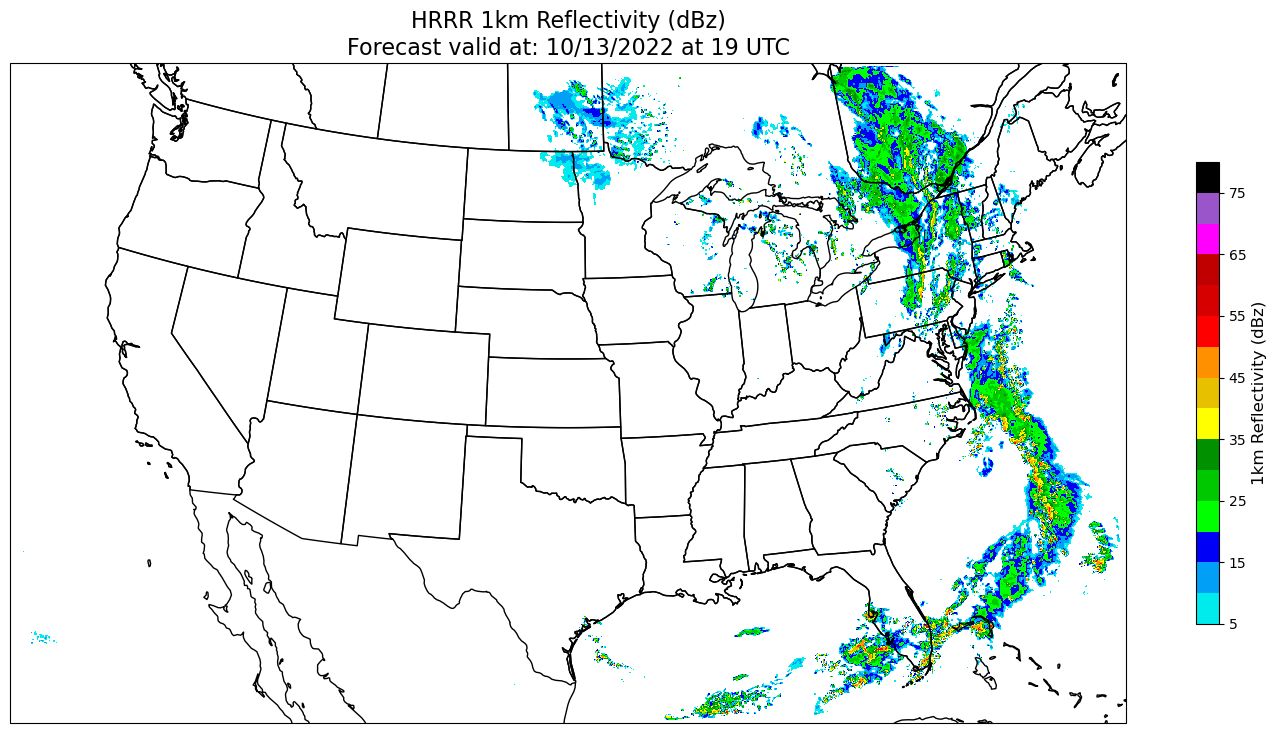

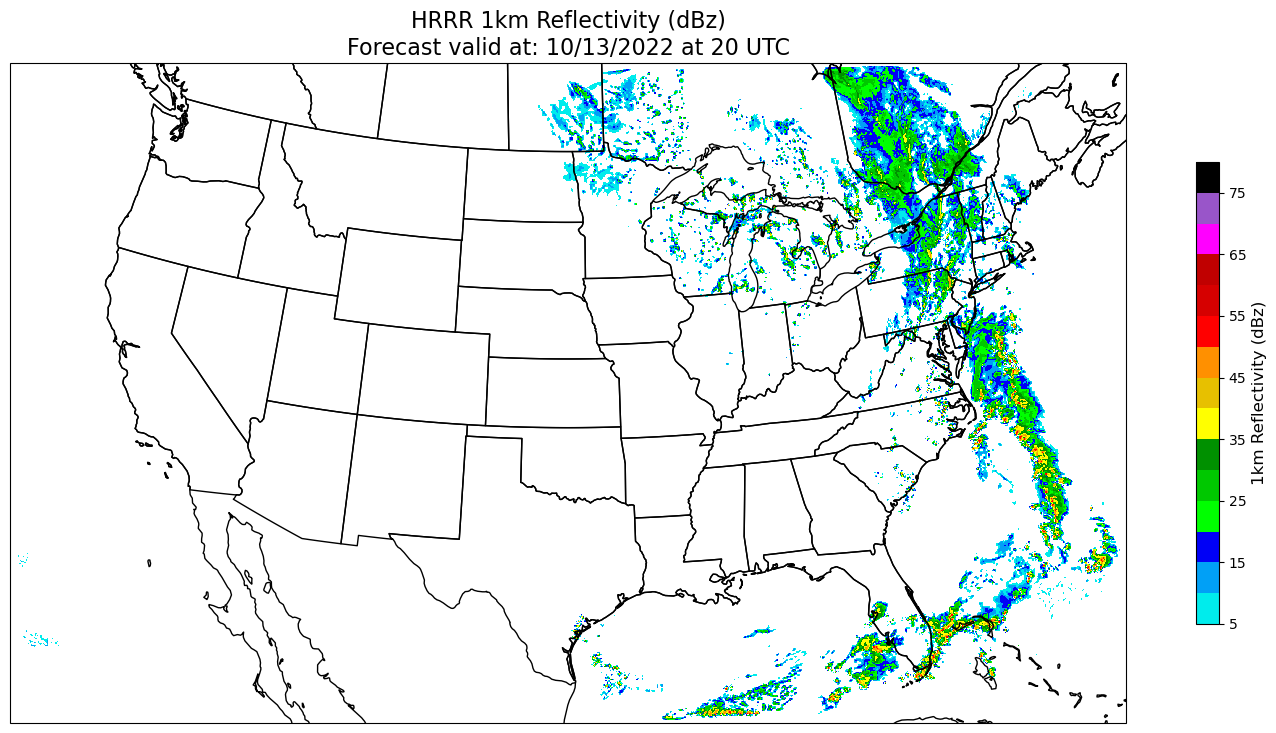

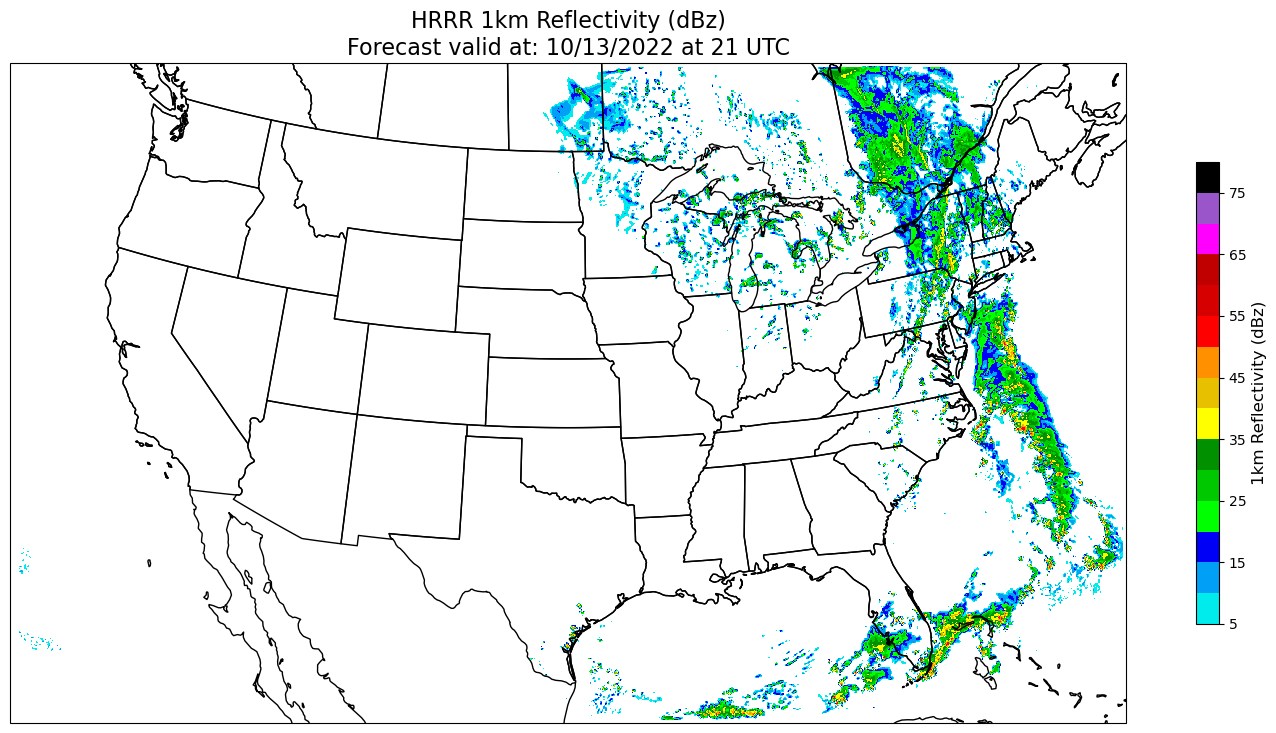

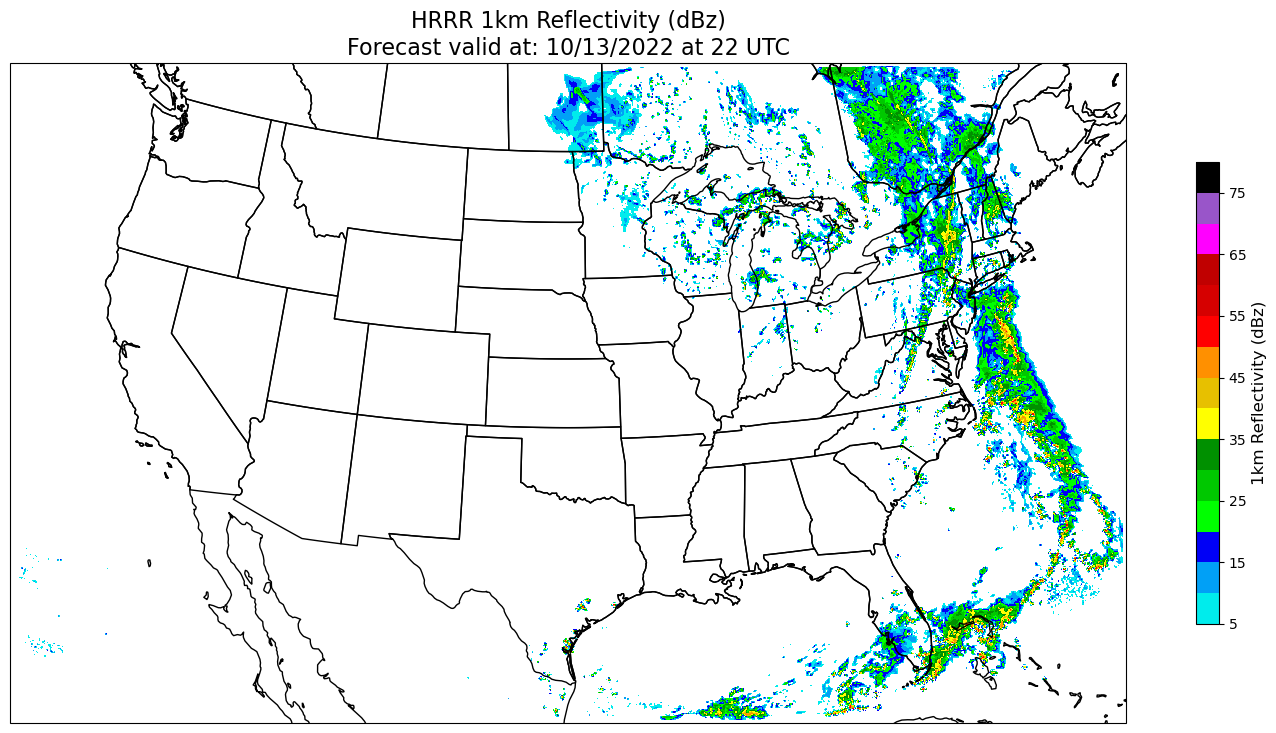

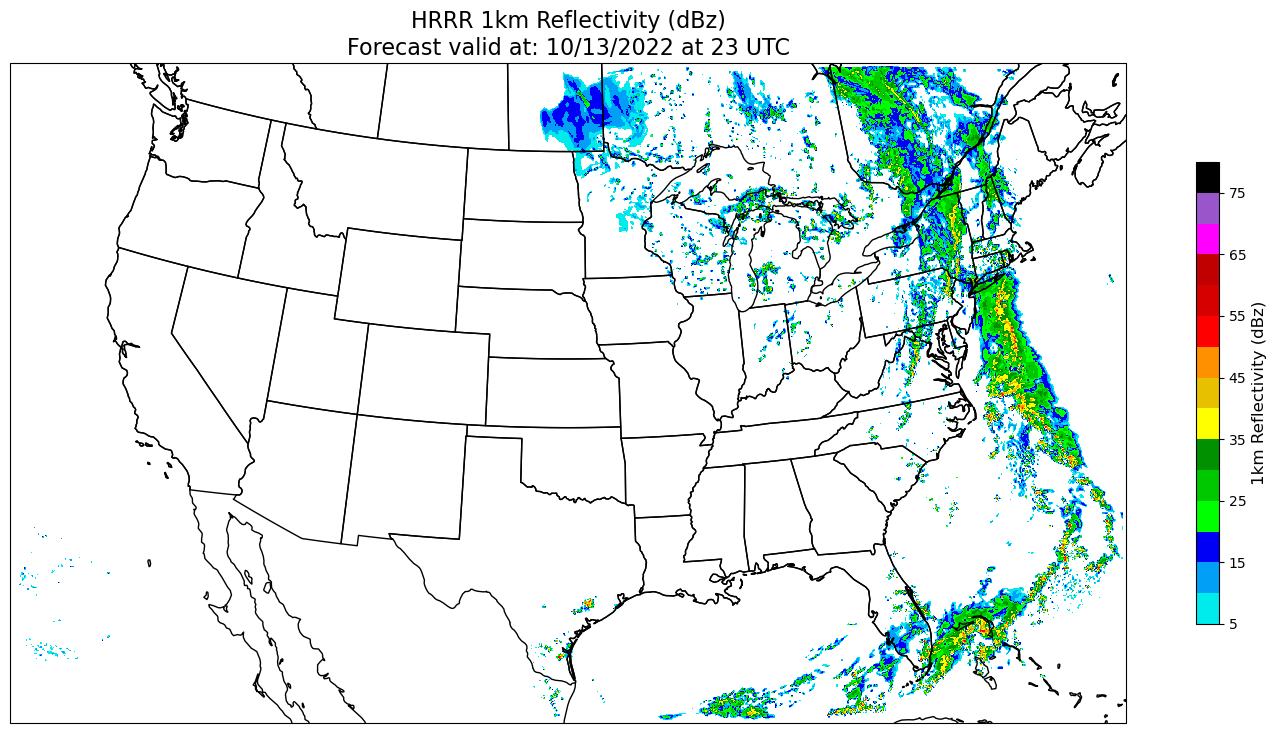

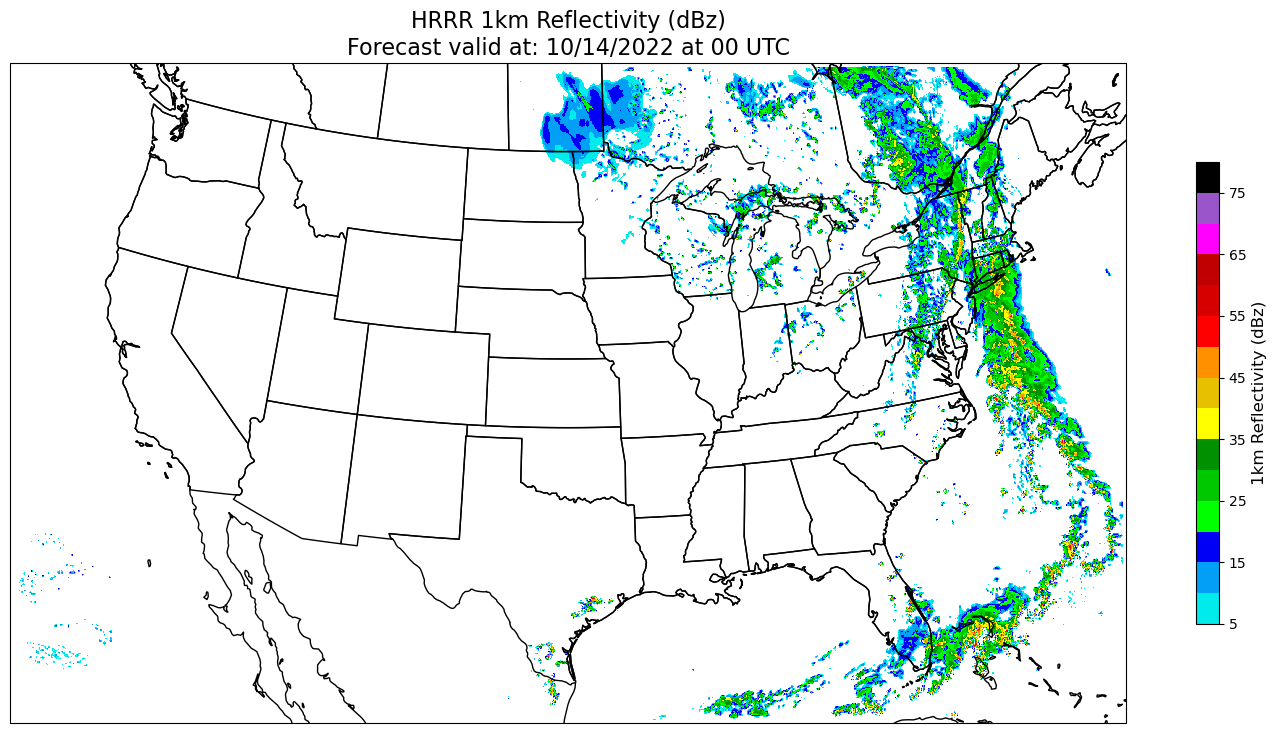

In [20]:
parameter = 'REFD'
hrStart = 0
hrStop = 6
hrInc = 1
for i in range (hrStart, hrStop, hrInc):
    make_regional_map(i, ds[parameter])
    

---
## Summary
* With a minimum of changes, we can adapt our initial 2-meter temperature notebook to different HRRR variables, such as 1 km reflectivity.
* **Matplotlib**'s `ax.pcolormesh` function is ideal for plotting raster fields, such as radar reflectivity.
* **Metpy**'s `colortables` provide several meteorologically-relevant color tables, which can be easily incorporated and modified in **matplotlib**.

## Things to try
* Save your maps to disk, instead of (or in addition to) within your notebook.
* Create a map whose domain covers a smaller region ... e.g. the Albany region, or another area of interest to you. If the region is small enough, consider adding [MetPy's county line](https://unidata.github.io/MetPy/latest/examples/plots/US_Counties.html) outlines.
* Create a near-realtime HRRR forecast loop. The most recent HRRR tends to appear on the AWS *hrrrzarr* bucket with an approximate 90-120 minute lag. Think about how you might dynamically determine the most recently available time, no matter when you run the notebook.
* Besides the single-level parameters, located in the *sfc* folder of the *hrrrzarr* bucket, explore the ones on isobaric surfaces, in the *prs* folder (these are analysis times only, no forecasts). 
